In [1]:
%%shell

# download the Penn-Fudan dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
unzip PennFudanPed.zip

--2020-02-24 06:07:48--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  4.70MB/s    in 9.1s    

2020-02-24 06:07:57 (5.62 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2020-02-24 06:07:57--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2020-02-24 06:07:57--
Total wall clock time: 9.3s
Downloaded: 1 files, 51M in 9.1s (5.62 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: Pen

In [0]:
def resize_512(img):
  sizes = img.size
  size = np.argmax(sizes)
  image_size = 512

  scale = image_size / sizes[size]
  if size:  
    second_value = int(sizes[0] * scale)
    toI = img.resize( (second_value, image_size))
  else:
    second_value = int(sizes[1] * scale)
    toI = img.resize ((image_size, second_value))

  new_im = Image.new(img.mode, size= (image_size, image_size))
  new_im.paste(toI)
  return new_im



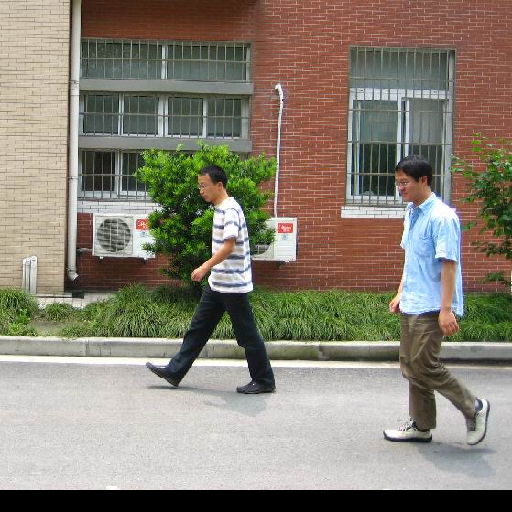

In [3]:
import numpy as np

from PIL import Image
image = Image.open('PennFudanPed/PNGImages/FudanPed00001.png').convert('RGB')
np.max(image.size )
resize_512(image)

In [4]:
np.array(image).shape

(536, 559, 3)

In [5]:
import torch.nn as nn
import torch
from  torchvision import transforms, datasets



# A = torch.as_tensor(image_np)
# tr = nn.Conv2d(A, 4, 3)
obj = transforms.ToTensor()
layer = nn.Conv2d(3, 50, kernel_size=1) 

A = obj(image)

tr = layer(A[None])
A[None].shape


torch.Size([1, 3, 536, 559])

In [0]:
import os 

imgs = list(sorted(os.listdir(os.path.join("PennFudanPed", "PNGImages"))))

# Image.open(imgs)
list_of_img = [ obj(resize_512(Image.open(os.path.join("PennFudanPed", "PNGImages", x)) )) for x in imgs ]



In [0]:
masks = list(sorted(os.listdir(os.path.join("PennFudanPed", "PedMasks"))))
list_of_masks_numbers = [np.unique( np.array((Image.open(os.path.join("PennFudanPed", "PedMasks", x) )) ))[1:] for x in masks]
list_of_masks = [np.array(resize_512( Image.open(os.path.join("PennFudanPed", "PedMasks", x) ) )) for x in masks]


In [0]:
def mapToBoxes(list_of_mask, list_of_masks_numbers):
  list_of_boxes = []
  for mask, x in zip (list_of_mask, list_of_masks_numbers):
    num_objs = len(x)
    boxes = []

    masks = mask == x[:, None, None]

    for i in range(num_objs):
      pos = np.where(masks[i])
      xmin = np.min(pos[1])
      xmax = np.max(pos[1])
      ymin = np.min(pos[0])
      ymax = np.max(pos[0])
      boxes.append([xmin, ymin, xmax, ymax])

    list_of_boxes.append(boxes)

  return list_of_boxes

In [0]:
def showImageWithBoxes(img, boxes):
  fig, ax = plt.subplots(1)
  ax.imshow(img)

  for x_min, y_min, x_max, y_max in boxes:
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min,y_min), width,height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

  plt.show()
    



In [0]:
def receptiveField(level):
  receptive_field = 1
  jump = 1
  kernel_size = 3
  stride = 2
  for x in range(level):
    receptive_field +=  (kernel_size - 1) * jump
    jump *= stride

  return receptive_field

In [11]:
receptiveField(7)

255

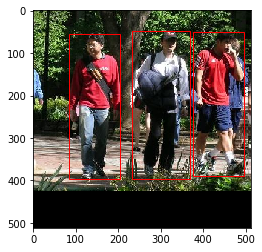

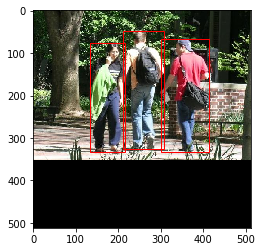

In [12]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt



positions = mapToBoxes(list_of_masks, list_of_masks_numbers)

for x in range(153, 155):
  showImageWithBoxes(list_of_img[x].permute(1,2,0), positions[x])


In [13]:
import math

def whichLvl(width, height):
  return int (7 + math.log2(  math.sqrt(width * height) / 512))


dic = {x:0 for x in range(0,8)}
for y in positions:
  for x_min, y_min, x_max, y_max in y:
    dic[whichLvl(x_max - x_min, y_max - y_min)] += 1

dic


{0: 0, 1: 2, 2: 4, 3: 14, 4: 99, 5: 271, 6: 33, 7: 0}

[[0 0 0 0]
 [0 0 0 0]]


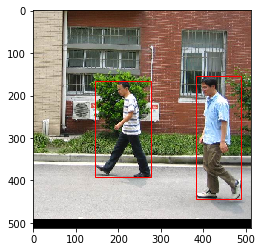

[[0 0 0 0]]


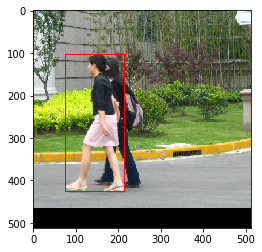

[[0 0 0 0]]


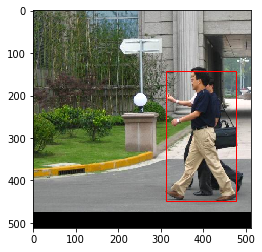

[[0 0 0 0]
 [0 0 0 0]]


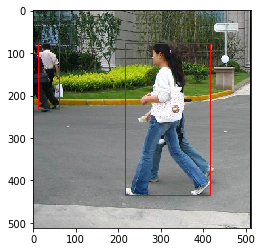

[[0 0 0 0]
 [0 0 0 0]]


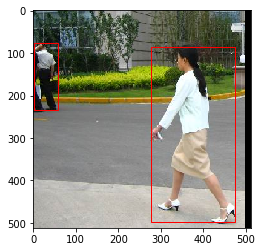

In [14]:
def toPyramidLvl(box):
  x_min, y_min, x_max, y_max = box
  lvl = whichLvl(x_max - x_min, y_max - y_min)
  if lvl < 3:
    lvl = 3
  
  rF = receptiveField(lvl)
  x_min, y_min, x_max, y_max = box

  center_x = (x_max + x_min) // 2
  center_y = (y_max + y_min) // 2
  
  center_x_feature_lvl = center_x //  2 ** lvl
  center_x = center_x_feature_lvl * 2 ** lvl
  center_y_feature_lvl = center_y //  2 ** lvl
  center_y = center_y_feature_lvl * 2 ** lvl


  x_box_min = center_x - rF // 2
  x_box_max = center_x + rF // 2
  y_box_min = center_y - rF // 2
  y_box_max = center_y + rF // 2

  left_offset = (x_min - x_box_min) / rF
  right_offset = (x_box_max - x_max) / rF
  up_offset = (y_min - y_box_min) / rF
  down_offet = (y_box_max - y_max) / rF

  return [lvl, center_x_feature_lvl, center_y_feature_lvl, left_offset, right_offset, up_offset, down_offet]



def fromPyramidLvl(parameters, lvl):
  center_x , center_y, left_offset, right_offset, up_offset, down_offet = parameters
  center_x , center_y = [center_x * 2 ** lvl, center_y * 2 ** lvl]
  rF = receptiveField(lvl)
  left_offset, right_offset, up_offset, down_offset = [int (rF * x) for x in [left_offset, right_offset, up_offset, down_offet] ]
  
  left_offset += center_x - rF // 2
  up_offset += center_y - rF // 2

  right_offset = center_x + rF // 2 - right_offset
  down_offset = center_y + rF // 2 - down_offset


  return [left_offset, up_offset, right_offset, down_offset]



par = toPyramidLvl(positions[100][0])
pa1 = fromPyramidLvl(par[1:], par[0])

for x in range(5):
  par = [toPyramidLvl(y) for y in positions[x] ]
  pa1 = [fromPyramidLvl(y[1:], y[0]) for y in par ]
  # print (pa1)
  print (np.array(positions[x]) - np.array(  pa1)) 
  showImageWithBoxes(list_of_img[x].permute(1,2,0), pa1)
  

In [0]:

this_is_current = positions[100]



def prepareForTraining(boxes):
  pyramid_levels = [3, 4, 5, 6, 7]
  
  size_at_pyramid_lvl = [ 512 // 2 ** x for x in pyramid_levels]

  pyramid_class = []
  pyramid_reg = []

  for x in size_at_pyramid_lvl:
    pyramid_class.append(torch.zeros(len(boxes),x, x, dtype=torch.long))
    pyramid_reg.append(torch.zeros(len(boxes), x, x, 4))

  for ind, y in enumerate(boxes):
    for x in y:
      temp = toPyramidLvl(x)
      pyramid_class[temp[0] - 3][ind, temp[2], temp[1]] = 1
      pyramid_reg[temp[0] - 3][ind, temp[2], temp[1]] = torch.tensor(temp[3:])
  
  out = []

  for x, y in zip(pyramid_class, pyramid_reg):
    x = x.view(-1)
    # print(x.shape)
    out.append([x, y] )
    #  out.append([x.view(x.shape[0], -1), 
    #  y.contiguous().view(y.shape[0], -1, 4)] )
    
  
  return out
  

# for x in range(5):
  # print (prepareForTraining(positions[:5])[x][0])
  # plt.imshow( prepareForTraining(positions[:5])[x][0][4] )
  # plt.show()

In [0]:


def intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

In [0]:



def boundingBoxFromPointAndPyramidLvl(y_on_pyramid_lvl, x_on_pyramid_lvl, lvl):
  scales = [ 2 ** 0, 2 ** (1/3), 2 ** (2/3)]
  receptive_field = receptiveField(lvl)
  x = x_on_pyramid_lvl * 2 ** lvl
  y = y_on_pyramid_lvl * 2 ** lvl

  bounding_boxes = []

  for a in scales:
    x_min = int( round( x - receptive_field // 2 * a ))
    x_max = int( round (x + receptive_field // 2 * a ))

    y_min = int( round( y - receptive_field * a ))
    y_max = int( round( y + receptive_field * a  ))
    bounding_boxes.append([x_min, y_min, x_max, y_max])

  return bounding_boxes


def calculateIoUOnPyramidLvl(bounding_boxes_of_an_images, lvl):
  image_height = 512
  height_on_pyramid_lvl = image_height // 2 ** lvl
  number_of_batches = len (bounding_boxes_of_an_images)
  pyramid_lvl = torch.zeros(number_of_batches,
                            height_on_pyramid_lvl,
                            height_on_pyramid_lvl, 3)

  cls = torch.zeros(number_of_batches,
                            height_on_pyramid_lvl,
                            height_on_pyramid_lvl, dtype=torch.long)
  for b, img in enumerate (bounding_boxes_of_an_images):
    for x in range(height_on_pyramid_lvl):
      for y in range(height_on_pyramid_lvl):
        for z, val in enumerate(boundingBoxFromPointAndPyramidLvl(y, x, lvl)): 
          for w in img:
            pyramid_lvl[b, y, x, z] = max (intersection_over_union(w, val), pyramid_lvl[b, y, x, z])
          # if any(pyramid_lvl[b, y, x] >= 0.5 ):
            # cls[b, y, x] = torch.argmax(pyramid_lvl[b, y, x]) + 1

  fclass = torch.zeros_like(pyramid_lvl)
  tclass = torch.ones_like(pyramid_lvl)

  return torch.where(pyramid_lvl < 0.5, fclass, tclass).view(-1, 3)
  # return cls.view(-1)


def toPyramidForTraining(bounding_boxes_of_an_images):
  return [calculateIoUOnPyramidLvl(bounding_boxes_of_an_images, x) for x in range(3, 8)]



# boundingBoxFromPoinAndPyramidLvl(0, 0, 7)

# val = calculateIoUOnPyramidLvl(positions[:8], 6)[0]
# nclas = torch.zeros_like(val)
# tclas = torch.ones_like(val)



# print (torch.where(val < 0.5, nclas, tclas))

ddfaf = toPyramidForTraining(positions[:8])
  

In [20]:
ddfaf[0].shape

torch.Size([32768, 3])

In [0]:
testing = prepareForTraining(positions[:8])

In [22]:
for x in range(5):
  print (sum(testing[x][0] ))

print(testing[2][0].shape)

tensor(1)
tensor(2)
tensor(10)
tensor(2)
tensor(0)
torch.Size([2048])


In [23]:
whichLvl(512,512)

7

In [24]:
receptiveField(6)

127

In [0]:

train_transform = transforms.Compose([resize_512, transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) ])

image_data = datasets.ImageFolder('PennFudanPed', transform=train_transform)


data_loader = torch.utils.data.DataLoader(image_data, batch_size=1, )

In [0]:

data_imgs = torch.empty((0,3,512,512))
data_masks = torch.empty((0,3,512,512))

for data, file in data_loader:

  if file == 1:
    data_imgs = torch.cat ((data_imgs, data), )
  else:
    data_masks = torch.cat((data_masks, data))

   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


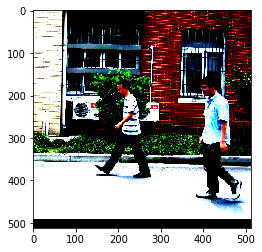

In [28]:
plt.imshow(data_imgs[0].permute(1, 2, 0))

In [0]:
class FPN(nn.Module):
    def __init__(self, feature_size=256):
        super(FPN, self).__init__()

        C3_size = 512
        C4_size = 1024
        C5_size = 2048


        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return [P3_x, P4_x, P5_x, P6_x, P7_x]

In [0]:
class RegressionModel(nn.Module):
    def __init__(self, num_features_in, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, 4, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        # return out.contiguous().view(out.shape[0], -1, 4)
        return out

In [0]:
class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, 3, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)

        # out is B x C x W x H, with C = n_classes + n_anchors
        # out1 = out.permute(0, 2, 3, 1)

        # batch_size, width, height, channels = out1.shape

        # out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

        # return out2.contiguous().view(x.shape[0], -1, self.num_classes)
        # print (out.permute(0, 2, 3, 1).shape)
        return out.permute(0, 2, 3, 1).contiguous().view(-1, 3)


In [0]:
import torchvision

class RetinaNet(nn.Module):
  def __init__(self):
    super(RetinaNet, self).__init__()

    mod = torchvision.models.resnet50(pretrained=True, progress=False)
    self.C3 = nn.Sequential( mod.conv1, mod.bn1, mod.relu, mod.maxpool, mod.layer1, mod.layer2)
    
    self.C4 = mod.layer3
    self.C5 = mod.layer4



    for x in [ self.C3 , self.C4 ,self.C5]:
      for y in x.parameters():
        y.requires_grad = False

    self.fpn = FPN()
    # self.regresion_P3 = RegressionModel(256)
    # self.regresion_P4 = RegressionModel(256)
    # self.regresion_P5 = RegressionModel(256)
    # self.regresion_P6 = RegressionModel(256)
    # self.regresion_P7 = RegressionModel(256)

    self.classifier_P3 = ClassificationModel(256)
    self.classifier_P4 = ClassificationModel(256)
    self.classifier_P5 = ClassificationModel(256)
    self.classifier_P6 = ClassificationModel(256)
    self.classifier_P7 = ClassificationModel(256)

  def forward(self, images):
    C3 = self.C3(images)
    C4 = self.C4(C3)
    C5 = self.C5(C4)

    P3_x, P4_x, P5_x, P6_x, P7_x = self.fpn([C3, C4, C5])

    # return [[ self.classifier_P3(P3_x), self.regresion_P3(P3_x)],\
    #         [self.classifier_P4(P4_x), self.regresion_P4(P4_x)],\
    #         [self.classifier_P5(P5_x), self.regresion_P5(P5_x)],\
    #         [self.classifier_P6(P6_x), self.regresion_P6(P6_x)],\
    #         [self.classifier_P7(P7_x), self.regresion_P7(P7_x)] ]
    return [self.classifier_P3(P3_x), self.classifier_P4(P4_x),
          self.classifier_P5(P5_x) ,self.classifier_P6(P6_x), 
          self.classifier_P7(P7_x)]



In [0]:
from typing import Optional

import torch
import torch.nn as nn
import torch.nn.functional as F




# based on:
# https://github.com/zhezh/focalloss/blob/master/focalloss.py

def one_hot(labels: torch.Tensor,
            num_classes: int,
            device: Optional[torch.device] = None,
            dtype: Optional[torch.dtype] = None,
            eps: Optional[float] = 1e-6) -> torch.Tensor:
    r"""Converts an integer label x-D tensor to a one-hot (x+1)-D tensor.
    Args:
        labels (torch.Tensor) : tensor with labels of shape :math:`(N, *)`,
                                where N is batch size. Each value is an integer
                                representing correct classification.
        num_classes (int): number of classes in labels.
        device (Optional[torch.device]): the desired device of returned tensor.
         Default: if None, uses the current device for the default tensor type
         (see torch.set_default_tensor_type()). device will be the CPU for CPU
         tensor types and the current CUDA device for CUDA tensor types.
        dtype (Optional[torch.dtype]): the desired data type of returned
         tensor. Default: if None, infers data type from values.
    Returns:
        torch.Tensor: the labels in one hot tensor of shape :math:`(N, C, *)`,
    Examples::
        >>> labels = torch.LongTensor([[[0, 1], [2, 0]]])
        >>> kornia.losses.one_hot(labels, num_classes=3)
        tensor([[[[1., 0.],
                  [0., 1.]],
                 [[0., 1.],
                  [0., 0.]],
                 [[0., 0.],
                  [1., 0.]]]]
    """
    if not torch.is_tensor(labels):
        raise TypeError("Input labels type is not a torch.Tensor. Got {}"
                        .format(type(labels)))
    if not labels.dtype == torch.int64:
        raise ValueError(
            "labels must be of the same dtype torch.int64. Got: {}" .format(
                labels.dtype))
    if num_classes < 1:
        raise ValueError("The number of classes must be bigger than one."
                         " Got: {}".format(num_classes))
    shape = labels.shape
    one_hot = torch.zeros(shape[0], num_classes, *shape[1:],
                          device=device, dtype=dtype)
    return one_hot.scatter_(1, labels.unsqueeze(1), 1.0) + eps


def focal_loss(
        input: torch.Tensor,
        target: torch.Tensor,
        alpha: float,
        gamma: float = 2.0,
        reduction: str = 'none',
        eps: float = 1e-8) -> torch.Tensor:
    r"""Function that computes Focal loss.
    See :class:`~kornia.losses.FocalLoss` for details.
    """
    if not torch.is_tensor(input):
        raise TypeError("Input type is not a torch.Tensor. Got {}"
                        .format(type(input)))

    if not len(input.shape) >= 2:
        raise ValueError("Invalid input shape, we expect BxCx*. Got: {}"
                         .format(input.shape))

    if input.size(0) != target.size(0):
        raise ValueError('Expected input batch_size ({}) to match target batch_size ({}).'
                         .format(input.size(0), target.size(0)))

    n = input.size(0)
    out_size = (n,) + input.size()[2:]
    if target.size()[1:] != input.size()[2:]:
        raise ValueError('Expected target size {}, got {}'.format(
            out_size, target.size()))

    if not input.device == target.device:
        raise ValueError(
            "input and target must be in the same device. Got: {}" .format(
                input.device, target.device))

    # compute softmax over the classes axis
    input_soft: torch.Tensor = F.softmax(input, dim=1) + eps

    # create the labels one hot tensor
    target_one_hot: torch.Tensor = one_hot(
        target, num_classes=input.shape[1],
        device=input.device, dtype=input.dtype)

    # compute the actual focal loss
    weight = torch.pow(-input_soft + 1., gamma)

    focal = -alpha * weight * torch.log(input_soft)
    loss_tmp = torch.sum(target_one_hot * focal, dim=1)

    if reduction == 'none':
        loss = loss_tmp
    elif reduction == 'mean':
        loss = torch.mean(loss_tmp)
    elif reduction == 'sum':
        loss = torch.sum(loss_tmp)
    else:
        raise NotImplementedError("Invalid reduction mode: {}"
                                  .format(reduction))
    return loss


class FocalLoss(nn.Module):
    r"""Criterion that computes Focal loss.
    According to [1], the Focal loss is computed as follows:
    .. math::
        \text{FL}(p_t) = -\alpha_t (1 - p_t)^{\gamma} \, \text{log}(p_t)
    where:
       - :math:`p_t` is the model's estimated probability for each class.
    Arguments:
        alpha (float): Weighting factor :math:`\alpha \in [0, 1]`.
        gamma (float): Focusing parameter :math:`\gamma >= 0`.
        reduction (str, optional): Specifies the reduction to apply to the
         output: ‘none’ | ‘mean’ | ‘sum’. ‘none’: no reduction will be applied,
         ‘mean’: the sum of the output will be divided by the number of elements
         in the output, ‘sum’: the output will be summed. Default: ‘none’.
    Shape:
        - Input: :math:`(N, C, *)` where C = number of classes.
        - Target: :math:`(N, *)` where each value is
          :math:`0 ≤ targets[i] ≤ C−1`.
    Examples:
        >>> N = 5  # num_classes
        >>> kwargs = {"alpha": 0.5, "gamma": 2.0, "reduction": 'mean'}
        >>> loss = kornia.losses.FocalLoss(**kwargs)
        >>> input = torch.randn(1, N, 3, 5, requires_grad=True)
        >>> target = torch.empty(1, 3, 5, dtype=torch.long).random_(N)
        >>> output = loss(input, target)
        >>> output.backward()
    References:
        [1] https://arxiv.org/abs/1708.02002
    """

    def __init__(self, alpha: float, gamma: float = 2.0,
                 reduction: str = 'none') -> None:
        super(FocalLoss, self).__init__()
        self.alpha: float = alpha
        self.gamma: float = gamma
        self.reduction: str = reduction
        self.eps: float = 1e-6

    def forward(  # type: ignore
            self,
            input: torch.Tensor,
            target: torch.Tensor) -> torch.Tensor:
        return focal_loss(input, target, self.alpha, self.gamma, self.reduction, self.eps)

In [34]:
import torch.optim as optim

# CUDA_LAUNCH_BLOCKING=1

model = RetinaNet()
model.cuda()
kwargs = {"alpha": 0.25, "gamma": 2, "reduction": 'mean'}
criterion_class = nn.BCELoss()
# criterion_class = nn.CrossEntropyLoss()


# criterion_class = FocalLoss(**kwargs)
# criterion_reg = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),  lr=0.001 )


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [35]:
from functools import reduce
import logging

logger = logging.getLogger(__name__)

model.train()

# for x , value in enumerate(list_of_img):
data_imgs = data_imgs.cuda()

for A in range(20):
  x_0 = 0
  print(A)
  for x in range(8, 160, 8):

    optimizer.zero_grad()

    result = model(data_imgs[x_0:x])
    

    q = toPyramidForTraining(positions[x_0:x] )
    
    loss = []
    for y, val in enumerate(result):
      loss.append( criterion_class(val, q[y].cuda()) )
      # loss.append( F.cross_entropy(val, q[y][0].cuda()) )

      # loss.append(criterion_reg(val[1], q[y][1].cuda())  )
    sum_loss = torch.tensor(0.)
    for y in loss:
      sum_loss += y
      y.backward(retain_graph=True)
    optimizer.step()


    print(f"loss: {sum_loss}")

    x_0 = x
    # optimizer.step()




0
loss: 3.463819742202759
loss: 0.8808819651603699
loss: 1.025029182434082
loss: 1.0167485475540161
loss: 0.8759939670562744
loss: 0.7214726209640503
loss: 0.6139918565750122
loss: 0.7169389724731445
loss: 0.47480344772338867
loss: 1.0238368511199951
loss: 1.038973331451416
loss: 1.0172460079193115
loss: 0.5368066430091858
loss: 0.6001782417297363
loss: 0.6220455765724182
loss: 0.5452905297279358
loss: 0.6902608275413513
loss: 0.5327656269073486
loss: 0.6249017119407654
1
loss: 0.4429410994052887
loss: 0.395388126373291
loss: 0.5777111053466797
loss: 0.718025803565979
loss: 0.6584362983703613
loss: 0.6810942888259888
loss: 0.5593870878219604
loss: 0.5992181301116943
loss: 0.31318923830986023
loss: 0.955647885799408
loss: 0.9396243095397949
loss: 0.7809295058250427
loss: 0.3800055682659149
loss: 0.44502145051956177
loss: 0.6001769304275513
loss: 0.49312907457351685
loss: 0.6485475897789001
loss: 0.5005171895027161
loss: 0.6123668551445007
2
loss: 0.47398725152015686
loss: 0.388593763113

In [0]:
model.eval()

rs = model(data_imgs[169:])

In [79]:
for x in range (5):
  print (torch.torch.topk(rs[x][:,0], 3) )

torch.return_types.topk(
values=tensor([0., 0., 0.], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([2, 1, 0], device='cuda:0'))
torch.return_types.topk(
values=tensor([0., 0., 0.], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([2, 1, 0], device='cuda:0'))
torch.return_types.topk(
values=tensor([0., 0., 0.], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([2, 1, 0], device='cuda:0'))
torch.return_types.topk(
values=tensor([0.7887, 0.5381, 0.4864], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([41, 33, 25], device='cuda:0'))
torch.return_types.topk(
values=tensor([0., 0., 0.], device='cuda:0', grad_fn=<TopkBackward>),
indices=tensor([2, 1, 0], device='cuda:0'))


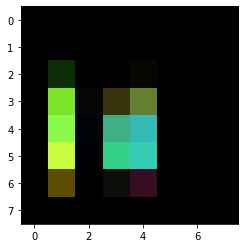

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


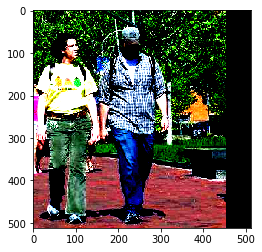

In [80]:
plt.imshow(rs[3].view(8,8, 3).cpu().detach().numpy())
plt.show()
plt.imshow(data_imgs[169].permute(1,2,0).cpu().detach().numpy())
plt.show()

In [0]:
PATH = './retina.pth'
torch.save(model.state_dict(), PATH)

In [0]:
mod = torchvision.models.resnet50(pretrained=True, progress=False)

In [40]:
mod.cuda()


torch.all(list (mod.layer3.named_parameters() )[3][1] == list (model.C4.named_parameters())[3][1] )

tensor(True, device='cuda:0')